In [12]:
%pylab inline
plt.rc('font',size=20)

Populating the interactive namespace from numpy and matplotlib


/Users/eddie/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from solvers import *
from utils import *

calc_e,_ = define_ising_mch_helpers()

In [3]:
# Generate example data set.
n = 5
allstates = bin_states(n,True)
def calc_observables(J):
    E = calc_e(allstates,J)
    return pair_corr( allstates, exp(-E-logsumexp(E)),concat=True )

p = random.rand(2**n)
p /= p.sum()

sisj = pair_corr(allstates,p,concat=True)

In [4]:
# Declare and call solver.
solver = Exact(5,sisj,calc_e,calc_observables)
soln = solver.solve()

In [7]:
soln['x']

array([ 0.0858,  0.1614, -0.1789, -0.0282, -0.0092, -0.0172,  0.0041, -0.0438,  0.0397,  0.0841,  0.1676, -0.2246,  0.162 ,  0.0932,  0.076 ])

In [8]:
from tosolve11 import tosolve5

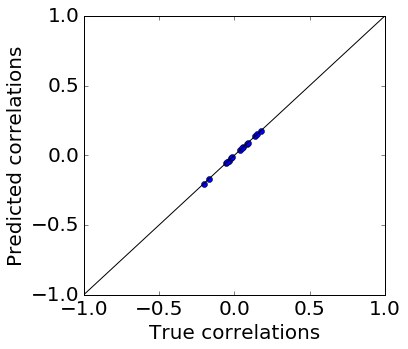

In [14]:
fig,ax = plt.subplots(figsize=(5.4,5))
ax.plot(sisj,tosolve5.get_stats(soln['x']),'o')
ax.plot([-1,1],[-1,1],'k-')
ax.set(xlabel='True correlations',ylabel='Predicted correlations')